# NBA Score Predictions Pipeline

### Necessary Imports

In [88]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_columns', None)
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm 
import seaborn as sns

from sklearn.linear_model import LinearRegression

import random as rnd
import statistics
import math
import numpy as np

### Lists/Dicts for Conferences, Teams, Abbrs, Names

In [89]:
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

team_names =     ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
                  'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
                  'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
                  'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
                  'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
                  'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
                  'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
                  'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
                  'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
                  'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_names_nocity = ['Jazz', 'Kings', 'Wizards', 'Celtics', 'Bucks', 'Thunder',
                  'Bulls', 'Suns', '76ers', 'Pelicans', 'Hornets', 'Lakers',
                  'Pacers', 'Raptors', 'Cavaliers', 'Nuggets', 'Timberwolves', 'Nets',
                  'Spurs', 'Mavericks', 'Rockets', 'Pistons', 'Trail Blazers', 'Hawks',
                  'Warriors', 'Heat', 'Clippers','Knicks', 'Grizzlies', 'Magic', 'League Average']

team_abbrs =     ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
                  'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
                  'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
                  'NYK', 'MEM', 'ORL', 'NBA']

team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_names_nocity_dict = {}
team_id_dict={}

for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]]=team_abbrs[i]
    
for i in range(len(team_names_nocity)):
    team_names_nocity_dict[team_names_nocity[i]]=team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]]=team_names[i]

### Webscrape 2022-2023 NBA Boxscore Data

In [90]:
url = 'https://stats.nba.com/stats/leaguegamelog'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'T',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'}

jsonData = requests.get(url, headers=headers, params=payload).json()


rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

df = pd.DataFrame(rows, columns=columns)
df.drop(['VIDEO_AVAILABLE'], axis=1, inplace=True)


df['FG2M'] = df.FGM - df.FG3M
df['FG2A'] = df.FGA - df.FG3A

df['FG2_PTS'] = df.FG2M * 2
df['FG3_PTS'] = df.FG3M * 3

df['OPP_TEAM_ABBR'] = df['MATCHUP'].str.strip().str[-3:]
df['OPP_PTS'] = df['PTS'] - df['PLUS_MINUS']

df['FRAC_ATT_2PT'] = df.FG2A / df.FGA
df['FRAC_ATT_3PT'] = df.FG3A / df.FGA

df['FRAC_MK_2PT'] = df.FG2M / df.FGM
df['FRAC_MK_3PT'] = df.FG3M / df.FGM

df['FRAC_PTS_2PT'] = df.FG2_PTS / df.PTS
df['FRAC_PTS_3PT'] = df.FG3_PTS / df.PTS
df['FRAC_PTS_FT'] = df.FTM / df.PTS 

df['MONTH'] = pd.DatetimeIndex(df['GAME_DATE']).month
df['YEAR'] = pd.DatetimeIndex(df['GAME_DATE']).year

def home_or_away(string):
    if string[4]=='@': return 'AWAY'
    elif string[4]=='v': return 'HOME'
    
df['HOME_AWAY'] = df['MATCHUP'].map(home_or_away)

df['CONFERENCE'] = df['TEAM_ABBREVIATION'].apply(lambda x: conferences.get(x))
df['OPP_CONFERENCE'] = df['OPP_TEAM_ABBR'].apply(lambda x: conferences.get(x))


df['DATE_MATCHUP'] = df['GAME_DATE'].str[5:] + ' ' + df['MATCHUP'].str[4:]
#df['DATE_MATCHUP'] = df['GAME_DATE'] + ' ' + df['MATCHUP'].str[4:]

df.TEAM_NAME = df.TEAM_ABBREVIATION.apply(lambda x: team_abbr_name_dict.get(x))

df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FG2M,FG2A,FG2_PTS,FG3_PTS,OPP_TEAM_ABBR,OPP_PTS,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,MONTH,YEAR,HOME_AWAY,CONFERENCE,OPP_CONFERENCE,DATE_MATCHUP
0,22022,1610612756,PHX,Phoenix Suns,0022200777,2023-02-01,PHX vs. ATL,L,240,35,86,0.407,4,28,0.143,26,31,0.839,12,32,44,22,8,4,16,13,100,-32,31,58,62,12,ATL,132,0.674419,0.325581,0.885714,0.114286,0.620000,0.120000,0.260000,2,2023,HOME,WEST,EAST,02-01 vs. ATL
1,22022,1610612737,ATL,Atlanta Hawks,0022200777,2023-02-01,ATL @ PHX,W,240,52,91,0.571,19,33,0.576,9,11,0.818,6,39,45,32,6,5,12,24,132,32,33,58,66,57,PHX,100,0.637363,0.362637,0.634615,0.365385,0.500000,0.431818,0.068182,2,2023,AWAY,EAST,WEST,02-01 @ PHX
2,22022,1610612762,UTA,Utah Jazz,0022200776,2023-02-01,UTA vs. TOR,W,240,44,83,0.530,17,47,0.362,26,30,0.867,13,36,49,29,3,11,16,17,131,3,27,36,54,51,TOR,128,0.433735,0.566265,0.613636,0.386364,0.412214,0.389313,0.198473,2,2023,HOME,WEST,EAST,02-01 vs. TOR
3,22022,1610612761,TOR,Toronto Raptors,0022200776,2023-02-01,TOR @ UTA,L,240,50,110,0.455,10,23,0.435,18,26,0.692,25,27,52,27,11,2,8,22,128,-3,40,87,80,30,UTA,131,0.790909,0.209091,0.800000,0.200000,0.625000,0.234375,0.140625,2,2023,AWAY,EAST,WEST,02-01 @ UTA
4,22022,1610612750,MIN,Minnesota Timberwolves,0022200774,2023-02-01,MIN vs. GSW,W,265,46,106,0.434,14,50,0.280,13,24,0.542,10,43,53,26,5,7,11,23,119,5,32,56,64,42,GSW,114,0.528302,0.471698,0.695652,0.304348,0.537815,0.352941,0.109244,2,2023,HOME,WEST,WEST,02-01 vs. GSW


### Team Average Dataframe

In [91]:
pivot_team_avg = pd.pivot_table(df, index=['TEAM_NAME','TEAM_ABBREVIATION'], aggfunc = 'mean')
df_team_avg = pivot_team_avg.reset_index()
df_team_avg.loc[30] = df_team_avg.drop(['TEAM_NAME','TEAM_ABBREVIATION'], axis=1).mean()
df_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_team_avg = df_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
df_team_avg = df_team_avg.drop(['MONTH','YEAR'],axis=1)
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR', 'PTS']
df_team_avg = df_team_avg[cols_to_move + [x for x in df_team_avg.columns if x not in cols_to_move]]

#df_team_avg

### Add Defense Allowed to Team Avg DataFrame

In [92]:
pivot_defense_allowed_team_avg = pd.pivot_table(df, index=['OPP_TEAM_ABBR'], aggfunc = 'mean')
df_defense_allowed_team_avg = pivot_defense_allowed_team_avg.reset_index()
df_defense_allowed_team_avg.loc[30] = df_defense_allowed_team_avg.drop(['OPP_TEAM_ABBR'], axis=1).mean()
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBREVIATION'})
df_defense_allowed_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_defense_allowed_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_defense_allowed_team_avg['TEAM_NAME'] = df_defense_allowed_team_avg['TEAM_ABBREVIATION'].map(team_abbr_name_dict)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.drop(['YEAR','TEAM_ID'], axis=1)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_defense_allowed_team_avg = df_defense_allowed_team_avg[cols_to_move + [x for x in df_defense_allowed_team_avg.columns if x not in cols_to_move]]
df_defense_allowed_team_avg.rename(columns=lambda x: 'OPP_'+x, inplace=True)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBR','OPP_TEAM_NAME':'TEAM_NAME'})


# Merge Offensive and Defensive Avg DFs

df_team_avg = pd.merge(df_team_avg, 
                       df_defense_allowed_team_avg,
                       right_on='TEAM_ABBR',
                       left_on='TEAM_ABBR',
                       how='left')
df_team_avg = df_team_avg.drop(['TEAM_NAME_y', 'OPP_PTS_y'],axis=1)
df_team_avg = df_team_avg.rename(columns={'TEAM_NAME_x':'TEAM_NAME','OPP_PTS_x':'OPP_PTS'})

#df_team_avg

### Webscrape Advanced Shooting DataFrame

In [93]:
tables = pd.read_html("https://www.basketball-reference.com/leagues/NBA_2023.html#shooting-team")

df_team_advshot = tables[12]
df_team_advshot.columns = [' '.join(col) for col in df_team_advshot.columns]
df_team_advshot.columns = df_team_advshot.columns.str.replace("Unnamed:", "")
df_team_advshot.columns = df_team_advshot.columns.str.replace("_level_0", "")
df_team_advshot = df_team_advshot.drop([' 0 Rk',
                                        ' 6  6_level_1',
                                        ' 13  13_level_1',
                                        ' 20  20_level_1',
                                        ' 23  23_level_1',
                                        ' 26  26_level_1',
                                        ' 29  29_level_1'], axis=1)

df_team_advshot = df_team_advshot.rename(columns={' 1 Team':'TEAM_NAME',
                                                  ' 2 G':'G',
                                                  ' 3 MP':'MP',
                                                  ' 4 FG%':'FG%',
                                                  ' 5 Dist.':'Dist'})


df_team_advshot['TEAM_ABBR'] = df_team_advshot['TEAM_NAME']
df_team_advshot['TEAM_ABBR']=df_team_advshot['TEAM_ABBR'].map(team_name_abbr_dict)

cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_team_advshot = df_team_advshot[cols_to_move + [x for x in df_team_advshot.columns if x not in cols_to_move]]


#df_team_advshot

### Create Master Data Frame with all variables 

In [94]:
df_team_master = pd.merge(df_team_avg, 
                       df_team_advshot,
                       right_on='TEAM_ABBR',
                       left_on='TEAM_ABBR',
                       how='left')
df_team_master = df_team_master.drop(['TEAM_NAME_y'],axis=1)
df_team_master = df_team_master.rename(columns={'TEAM_NAME_x':'TEAM_NAME'})

#df_team_master

### Function to return a teams dataframe

In [95]:
def get_team_df(TEAM_ABBR):
    team_df = df[df['TEAM_ABBREVIATION']==TEAM_ABBR]
    return team_df

### Webscrape NBA Records Data

In [96]:
columns = ['TEAM_ABBR','TEAM_NAME','CONFERENCE','GAMES','WINS','LOSES','WIN_PER','LAST_10_WINS','LAST_10_LOSES','HOME_WINS','HOME_LOSES','AWAY_WINS','AWAY_LOSES',
           'WEST_WINS', 'WEST_LOSES', 'EAST_WINS', 'EAST_LOSES']
data_records=[]
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

for i in df.TEAM_ABBREVIATION.unique(): 
    
    team_abbr = i
    
    team_name = team_abbr_name_dict[i]
    
    games = df[(df['TEAM_ABBREVIATION']==i)]['WL'].count() 
    
    wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')]['WL'].count()
    loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')]['WL'].count()
    
    win_per = wins/games
    
    last_10_df = get_team_df(i).head(10)
    
    last_10_wins = last_10_df[last_10_df['WL']=='W']['WL'].count()
    last_10_loses = last_10_df[last_10_df['WL']=='L']['WL'].count()
    
    home_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    home_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    
    away_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    away_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    
    west_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    west_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    
    east_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    east_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    
    conference = conferences[i]
    
    values = [team_abbr, team_name, conference, games, wins, loses, win_per, last_10_wins, last_10_loses, home_wins, home_loses, away_wins, away_loses,
              west_wins, west_loses, east_wins, east_loses]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data_records.append(a_dictionary)
    
df_records=pd.DataFrame(data_records).sort_values('WINS',ascending=False).reset_index(drop=True)


#df_records

### Merge Records Data onto master dataframe

In [97]:
df_team_master = pd.merge(df_records, 
                       df_team_master,
                       right_on='TEAM_ABBR',
                       left_on='TEAM_ABBR',
                       how='left')
df_team_master = df_team_master.drop(['TEAM_NAME_y'],axis=1)
df_team_master = df_team_master.rename(columns={'TEAM_NAME_x':'TEAM_NAME'})

df_team_master

,TEAM_ABBR,TEAM_NAME,CONFERENCE,GAMES,WINS,LOSES,WIN_PER,LAST_10_WINS,LAST_10_LOSES,HOME_WINS,HOME_LOSES,AWAY_WINS,AWAY_LOSES,WEST_WINS,WEST_LOSES,EAST_WINS,EAST_LOSES,PTS,AST,BLK,DREB,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OPP_PTS,OREB,PF,PLUS_MINUS,REB,STL,TEAM_ID,TOV,OPP_AST,OPP_BLK,OPP_DREB,OPP_FG2A,OPP_FG2M,OPP_FG2_PTS,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FG3_PTS,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FRAC_ATT_2PT,OPP_FRAC_ATT_3PT,OPP_FRAC_MK_2PT,OPP_FRAC_MK_3PT,OPP_FRAC_PTS_2PT,OPP_FRAC_PTS_3PT,OPP_FRAC_PTS_FT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_MIN,OPP_MONTH,OPP_OPP_PTS,OPP_OREB,OPP_PF,OPP_PLUS_MINUS,OPP_REB,OPP_STL,OPP_TOV,G,MP,FG%,Dist,% of FGA by Distance 2P,% of FGA by Distance 0-3,% of FGA by Distance 3-10,% of FGA by Distance 10-16,% of FGA by Distance 16-3P,% of FGA by Distance 3P,FG% by Distance 2P,FG% by Distance 0-3,FG% by Distance 3-10,FG% by Distance 10-16,FG% by Distance 16-3P,FG% by Distance 3P,% of FG Ast'd 2P,% of FG Ast'd 3P,Dunks %FGA,Dunks Md.,Layups %FGA,Layups Md.,Corner %3PA,Corner 3P%
0,BOS,Boston Celtics,EAST,52,37,15,0.711538,7,3,20,6,17,9,14,4,23,11,118.173077,26.346154,5.403846,35.230769,46.519231,26.346154,52.692308,41.942308,15.615385,0.370519,46.846154,88.461538,41.961538,0.475558,0.525228,0.474772,0.628537,0.371463,0.446293,0.394699,0.159008,22.480769,18.634615,0.831481,243.365385,111.980769,9.711538,18.826923,6.192308,44.942308,6.384615,1.610613e+09,13.500000,22.615385,3.750000,34.057692,57.519231,30.557692,61.115385,32.903846,11.596154,0.353635,34.788462,90.423077,42.153846,0.467365,0.636301,0.363699,0.724365,0.275635,0.547110,0.309414,0.143477,20.576923,16.076923,0.779942,243.365385,8.096154,118.173077,9.615385,19.480769,-6.192308,43.673077,6.500000,12.807692,51,12415,0.467,14.3,0.638,0.207,0.222,0.114,0.095,0.362,0.531,0.686,0.458,0.441,0.471,0.355,0.450,0.764,0.052,217,0.275,693,0.173,0.376
1,DEN,Denver Nuggets,WEST,51,35,16,0.686275,7,3,23,4,12,12,24,9,11,7,116.647059,28.647059,4.431373,32.686275,55.176471,31.431373,62.862745,30.882353,12.254902,0.394255,36.764706,86.058824,43.686275,0.509176,0.641150,0.358850,0.717634,0.282366,0.539979,0.314628,0.145393,22.803922,17.019608,0.748255,240.980392,112.725490,10.098039,19.294118,3.921569,42.784314,7.470588,1.610613e+09,15.019608,25.666667,4.352941,30.450980,52.980392,29.705882,59.411765,33.450980,11.686275,0.346843,35.058824,86.431373,41.392157,0.479922,0.612409,0.387591,0.718391,0.281609,0.531170,0.307188,0.161642,23.882353,18.254902,0.765039,240.980392,8.000000,116.647059,9.882353,20.196078,-3.921569,40.333333,7.666667,13.901961,51,12290,0.479,13.8,0.613,0.236,0.229,0.091,0.056,0.387,0.561,0.752,0.458,0.425,0.395,0.349,0.529,0.851,0.056,228,0.291,781,0.259,0.380
2,MIL,Milwaukee Bucks,EAST,51,34,17,0.666667,7,3,21,5,13,12,12,4,22,13,114.254902,24.764706,5.137255,36.960784,50.392157,27.215686,54.431373,39.725490,14.313725,0.361431,42.941176,90.117647,41.529412,0.462000,0.558870,0.441130,0.653350,0.346650,0.474927,0.376653,0.148420,22.843137,16.882353,0.743235,241.960784,111.921569,11.882353,18.352941,2.333333,48.843137,6.784314,1.610613e+09,15.333333,23.058824,4.294118,33.450980,58.588235,30.176471,60.352941,33.431373,11.686275,0.347059,35.058824,92.019608,41.862745,0.456549,0.636196,0.363804,0.719685,0.280315,0.540307,0.311801,0.147892,21.215686,16.509804,0.780824,241.960784,8.039216,114.254902,10.882353,18.941176,-2.333333,44.333333,7.313725,12.431373,51,12340,0.455,14.1,0.637,0.235,0.183,0.140,0.078,0.363,0.515,0.676,0.417,0.446,0.386,0.350,0.468,0.763,0.053,213,0.247,634,0.191,0.356
3,PHI,Philadelphia 76ers,EAST,50,33,17,0.660000,8,2,20,8,13,9,13,5,20,12,114.480000,25.300000,4.820000,32.020000,51.220000,27.940000,55.880000,33.420000,12.860000,0.381340,38.580000,84.640000,40.800000,0.483040,0.604168,0.395832,0.682270,0.317730,0.489813,0.335288,0.174899,24.220000,20.020000,0.825140,242.500000,110.700000,8.660000,20.720000,3.780

### Function to return DF with R2 for a specified stat

In [98]:
def r2_comparison_from_y(df, staty):
    
    pd.set_option('display.max_rows', None)
    
    df_new = df.copy()
    
    try: df_new = df_new.drop(columns=['TEAM_NAME'])
    except: pass
    try: df_new = df_new.drop(columns=['TEAM_ABBR'])
    except: pass
    
    df_out = pd.DataFrame(columns=['x','y','r2'])
    
    y=df_new[staty]
    y=y.fillna(y.mean())
    
    for i in df_new.columns:
        x=df_new[i]
        try: x=x.fillna(x.mean())
        except: x=x.fillna(0)
        if is_numeric_dtype(df_new[i]):
            model = LinearRegression()
            model = model.fit(x.values.reshape(-1, 1), y)
            r2= model.score(x.values.reshape(-1, 1), y)
            df_temp = pd.DataFrame([[i, staty, r2]], columns=['x','y','r2'])
            df_out = df_out.append(df_temp)
        
    df_out = df_out.sort_values(by=['r2'],ascending=False).reset_index(drop=True)
    return df_out

r2_comparison_from_y(df_team_master, 'WINS')

,x,y,r2
0,WINS,WINS,1.000000
1,WIN_PER,WINS,0.991521
2,LOSES,WINS,0.970905
3,OPP_PLUS_MINUS,WINS,0.889047
4,PLUS_MINUS,WINS,0.889047
5,HOME_LOSES,WINS,0.799962
6,HOME_WINS,WINS,0.778429
7,AWAY_LOSES,WINS,0.671422
8,AWAY_WINS,WINS,0.557598
9,OPP_PTS,WINS,0.494058


### Function that webscrapes and displays todays NBA matchups

In [99]:
def today_matchups():
    url = "https://www.espn.com/nba/scoreboard"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    date = soup.find('h3', class_="Card__Header__Title Card__Header__Title--no-theme").text

    games = soup.find_all("div", class_='Scoreboard__RowContainer flex flex-column flex-auto')
    games_data = []

    df = pd.DataFrame()

    for game in games:
        game_data = {}
        away_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[0]
        home_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[1]
        game_data['Date'] = date
        game_data["away_tm"] = away_tm.text
        #game_data["away_tm_abbr"] = team_names_nocity_dict[away_tm.text]
        
        game_data["home_tm"] = home_tm.text
        #game_data["home_tm_abbr"] = team_names_nocity_dict[home_tm.text]
        
        
        games_data.append(game_data)

    df = pd.DataFrame(games_data)
    
    print(soup.title.text)
    print(date)
    display(df)

today_matchups()

NBA Basketball Scores - NBA Scoreboard - ESPN
Wednesday, February 1, 2023


,Date,away_tm,home_tm
0,"Wednesday, February 1, 2023",Magic,76ers
1,"Wednesday, February 1, 2023",Trail Blazers,Grizzlies
2,"Wednesday, February 1, 2023",Nets,Celtics
3,"Wednesday, February 1, 2023",Thunder,Rockets
4,"Wednesday, February 1, 2023",Warriors,Timberwolves
5,"Wednesday, February 1, 2023",Kings,Spurs
6,"Wednesday, February 1, 2023",Raptors,Jazz
7,"Wednesday, February 1, 2023",Hawks,Suns
8,"Wednesday, February 1, 2023",Wizards,Pistons


### Function that simulates a matchup a specified number of times

In [111]:
# Team 1 - Away
# Team 2 - Home

def multi_game_simulations(n, team1abbr, team2abbr):
    
    def gauss_game_sim(team1abbr, team2abbr):
        
        df1 = df[df.TEAM_ABBREVIATION==team1abbr]
        df1_A = df1[df1.HOME_AWAY == 'AWAY']
        df1_L1 = df1.head(1)
        df1_L3 = df1.head(3)
        df1_L7 = df1.head(7)
        df1_L10 = df1.head(10)
        
        df2 = df[df.TEAM_ABBREVIATION==team2abbr]
        df2_H = df2[df2.HOME_AWAY == 'HOME']
        df2_L1 = df2.head(1)
        df2_L3 = df2.head(3)
        df2_L7 = df2.head(7)
        df2_L10 = df2.head(10)
        
        # 30 Percent Weight - Overall
        team1Score_all = int(round(rnd.gauss(df1.PTS.mean(),df1.PTS.std())+rnd.gauss(df2.OPP_PTS.mean(),df2.OPP_PTS.std()))/2)
        team2Score_all =int(round(rnd.gauss(df2.PTS.mean(),df2.PTS.std())+rnd.gauss(df1.OPP_PTS.mean(),df1.OPP_PTS.std()))/2)
        
        # 30 Percent Weight - Away vs Home
        team1AScore = int(round(rnd.gauss(df1_A.PTS.mean(),df1_A.PTS.std())+rnd.gauss(df2_H.OPP_PTS.mean(),df2_H.OPP_PTS.std()))/2)
        team2HScore = int(round(rnd.gauss(df2_H.PTS.mean(),df2_H.PTS.std())+rnd.gauss(df1_A.OPP_PTS.mean(),df1_A.OPP_PTS.std()))/2)
        
        # 40 Percent - Trends
        team1_L1Score = df1_L1.PTS
        team2_L1Score = df2_L1.PTS
        
        team1_L3Score = int(round(rnd.gauss(df1_L3.PTS.mean(),df1_L3.PTS.std())+rnd.gauss(df2_L3.OPP_PTS.mean(),df2_L3.OPP_PTS.std()))/2)
        team2_L3Score = int(round(rnd.gauss(df2_L3.PTS.mean(),df2_L3.PTS.std())+rnd.gauss(df1_L3.OPP_PTS.mean(),df1_L3.OPP_PTS.std()))/2)
        
        team1_L7Score = int(round(rnd.gauss(df1_L7.PTS.mean(),df1_L7.PTS.std())+rnd.gauss(df2_L7.OPP_PTS.mean(),df2_L7.OPP_PTS.std()))/2)
        team2_L7Score = int(round(rnd.gauss(df2_L7.PTS.mean(),df2_L7.PTS.std())+rnd.gauss(df1_L7.OPP_PTS.mean(),df1_L7.OPP_PTS.std()))/2)
        
        team1_L10Score = int(round(rnd.gauss(df1_L10.PTS.mean(),df1_L10.PTS.std())+rnd.gauss(df2_L10.OPP_PTS.mean(),df2_L10.OPP_PTS.std()))/2)
        team2_L10Score = int(round(rnd.gauss(df2_L10.PTS.mean(),df2_L10.PTS.std())+rnd.gauss(df1_L10.OPP_PTS.mean(),df1_L10.OPP_PTS.std()))/2)
        
        # Weigh in previous matchup? 20 percent
        try:
            df1_past = df1[df1.OPP_TEAM_ABBR == team2abbr]
            team1_pastScore = int(round(rnd.gauss(df1_past.PTS.mean(),df1_past.PTS.std())))
            team2_pastScore = int(round(rnd.gauss(df1_past.OPP_PTS.mean(),df1_past.OPP_PTS.std())))
            team1Score = int(round((team1Score_all*3) + (team1AScore*3) +
                                   team1_L1Score + team1_L3Score + team1_L7Score + team1_L10Score + (team1_pastScore*2))/12)
            team2Score = int(round((team2Score_all*3) +
                                   (team2HScore*3) + team2_L1Score + team2_L3Score + team2_L7Score + team2_L10Score + (team2_pastScore*2))/12)
        except:
            team1Score = int(round((team1Score_all*3) + (team1AScore*3) + team1_L1Score + team1_L3Score + team1_L7Score + team1_L10Score)/10)
            team2Score = int(round((team2Score_all*3) + (team2HScore*3) + team2_L1Score + team2_L3Score + team2_L7Score + team2_L10Score)/10)
        
        # Factor in Turnovers 
        team1TOV = (rnd.gauss(df1.TOV.mean(),df1.TOV.std()) + rnd.gauss(df[df.OPP_TEAM_ABBR==team1abbr].TOV.mean(),df[df.OPP_TEAM_ABBR==team1abbr].TOV.std()))/2
        team2TOV = (rnd.gauss(df2.TOV.mean(),df2.TOV.std()) + rnd.gauss(df[df.OPP_TEAM_ABBR==team2abbr].TOV.mean(),df[df.OPP_TEAM_ABBR==team2abbr].TOV.std()))/2
        
        TOV_diff = team2TOV-team1TOV
        
        #Pts off turnover - assuming next shot 50% fg equating to 1 point
        team1Score = team1Score + (TOV_diff/2)
        team2Score = team2Score - (TOV_diff/2)
        
        if team1Score > team2Score:
            return 1, team1Score, team2Score
        elif team1Score < team2Score:
            return -1, team1Score, team2Score
        else: return 0, team1Score, team2Score
    
    gameResults = []
    team1Wins = 0
    team2Wins = 0
    Ties = 0
    team1scores=[]
    team2scores=[]
    for i in range(n):
        gm, tm1sc, tm2sc = gauss_game_sim(team1abbr, team2abbr)
        team1scores.append(tm1sc)
        team2scores.append(tm2sc)
        gameResults.append(gm)
        if gm == 1:
            team1Wins += 1
        elif gm == -1:
            team2Wins += 1
        else: Ties += 1
            
    team1WinPer = team1Wins/(n)
    team2WinPer = team2Wins/(n)
    TiePer = Ties/(n)
    
    team1MeanSc = statistics.mean(team1scores)
    team2MeanSc = statistics.mean(team2scores)

    return team1WinPer, team2WinPer, team1MeanSc, team2MeanSc, team1scores, team2scores

### Todays matchups with with n-simulations win% and mean score for each matchup 

NBA Basketball Scores - NBA Scoreboard - ESPN
Wednesday, February 1, 2023
Through 100 simulations


,Date,away_tm,away_sim_W%,away_mean_sc,home_tm,home_sim_W%,home_mean_sc
0,"Wednesday, February 1, 2023",Magic,0.170000,107.547469,76ers,0.830000,112.772531
1,"Wednesday, February 1, 2023",Trail Blazers,0.500000,114.138522,Grizzlies,0.500000,114.441478
2,"Wednesday, February 1, 2023",Nets,0.020000,107.724186,Celtics,0.980000,119.925814
3,"Wednesday, February 1, 2023",Thunder,0.470000,111.818560,Rockets,0.530000,112.311440
4,"Wednesday, February 1, 2023",Warriors,0.520000,117.248360,Timberwolves,0.480000,117.071640
5,"Wednesday, February 1, 2023",Kings,0.910000,120.572886,Spurs,0.090000,112.717114
6,"Wednesday, February 1, 2023",Raptors,0.530000,115.978220,Jazz,0.470000,116.571780
7,"Wednesday, February 1, 2023",Hawks,0.690000,116.389358,Suns,0.310000,113.710642
8,"Wednesday, February 1, 2023",Wizards,0.900000,118.688287,Pistons,0.100000,111.181713


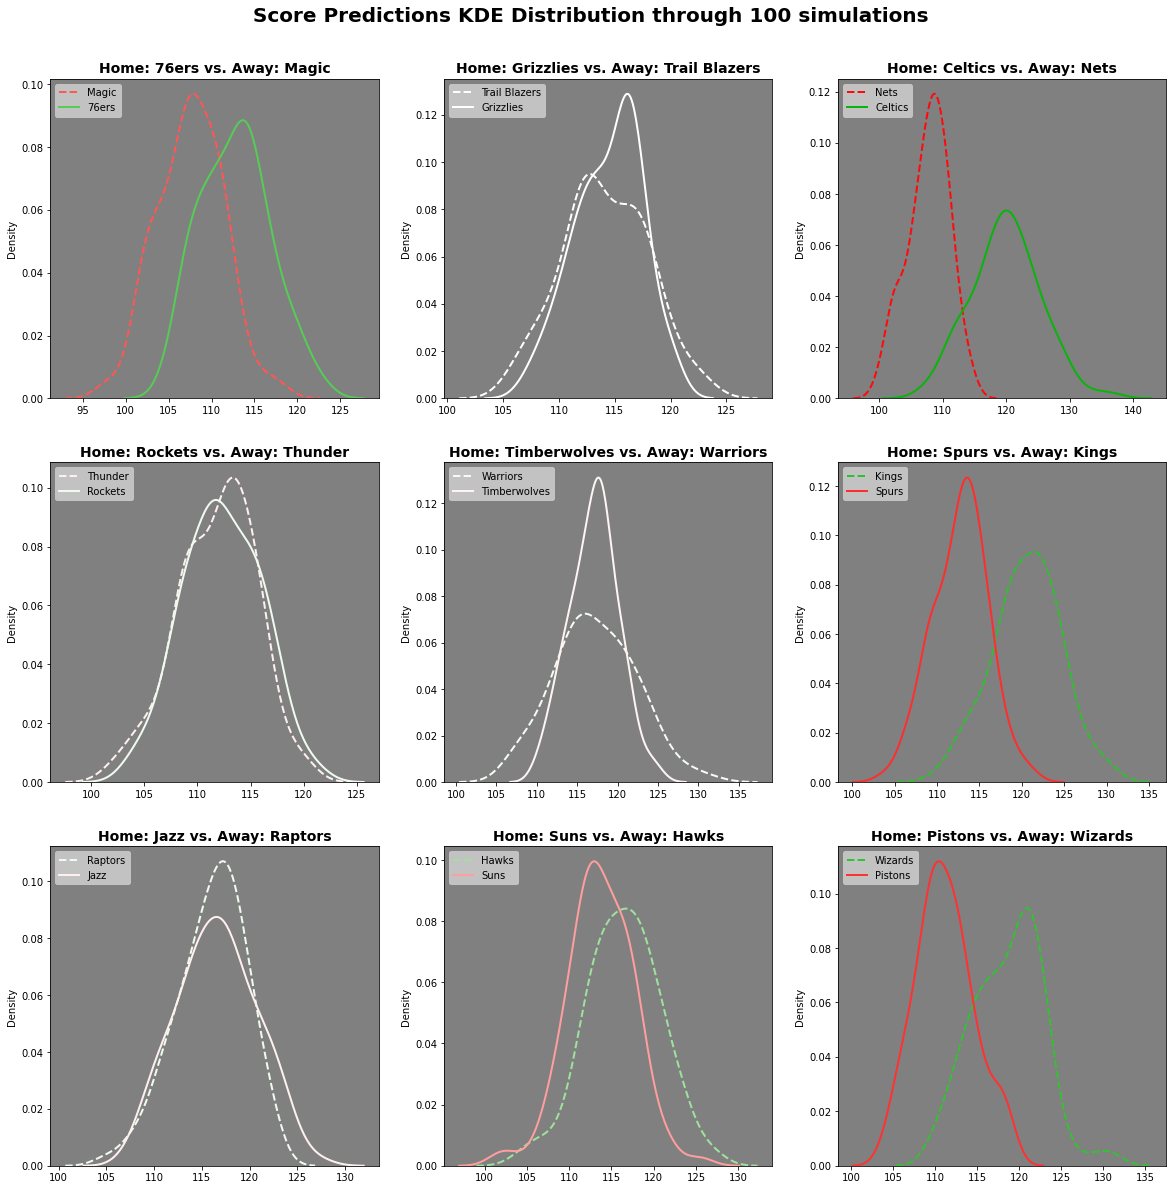

In [113]:
def today_multi_preds(n):
    url = "https://www.espn.com/nba/scoreboard"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    date = soup.find('h3', class_="Card__Header__Title Card__Header__Title--no-theme").text

    games = soup.find_all("div", class_='Scoreboard__RowContainer flex flex-column flex-auto')
    games_data = []

    df = pd.DataFrame()
    
    i,j=0,0
    PLOTS_PER_ROW = 3
    
    cdict = {'red': ((0.0, 0.0, 0.0),
                (0.5, 1.0, 1.0),
                (1.0, 1.0, 0.7)),

        'green': ((0.0, 0.7, 0.7),
                  (0.5, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),

         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 1.0, 1.0),
                  (1.0, 0.0, 0.0))
         }
    GnRd = colors.LinearSegmentedColormap('GnRd', cdict).reversed()
    
    fig, axs = plt.subplots(nrows=math.ceil(len(games)/PLOTS_PER_ROW),ncols=PLOTS_PER_ROW, figsize=(20, 20))
    
    fig.suptitle(f'Score Predictions KDE Distribution through {n} simulations', y=0.93, fontsize=20, fontweight='bold')
    
    for game in games:
        game_data = {}
        
        away_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[0]
        home_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[1]
        
        away_sim_Wper, home_sim_Wper, away_mn_sc, home_mn_sc, away_scores, home_scores = multi_game_simulations(n, team_names_nocity_dict[away_tm.text], team_names_nocity_dict[home_tm.text])
        
        game_data['Date'] = date
        
        game_data["away_tm"] = away_tm.text
        #game_data["away_tm_abbr"] = team_names_nocity_dict[away_tm.text]
        game_data[f"away_sim_W%"] = away_sim_Wper
        game_data[f"away_mean_sc"] = away_mn_sc
        
        game_data["home_tm"] = home_tm.text
        #game_data["home_tm_abbr"] = team_names_nocity_dict[home_tm.text]
        game_data[f"home_sim_W%"] = home_sim_Wper
        game_data[f"home_mean_sc"] = home_mn_sc
        
        games_data.append(game_data)
        axs[i][j].set_facecolor('grey')
        sns.kdeplot(np.array(away_scores), ax=axs[i][j], color=GnRd(away_sim_Wper), linewidth=2, linestyle='--', label=away_tm.text)
        sns.kdeplot(np.array(home_scores), ax=axs[i][j], color=GnRd(home_sim_Wper), linewidth=2, label=home_tm.text)
        
        axs[i][j].legend(loc='upper left', facecolor='lightgrey')
        
        axs[i][j].set_title(f'Home: {home_tm.text} vs. Away: {away_tm.text}', fontsize=14, fontweight='bold')
        
        j+=1
        if j%PLOTS_PER_ROW==0:
            i+=1
            j=0

    df = pd.DataFrame(games_data)
    
    print(soup.title.text)
    print(date)
    print(f'Through {n} simulations')
    
    df = df.style.background_gradient(axis=None, subset=['away_sim_W%','home_sim_W%'], cmap=GnRd, vmin=0.25, vmax=0.75)
    display(df)

    plt.show()

today_multi_preds(100)